# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center> Лабораторная работа №2. Рекомендательные системы </center>

* В данной лабораторной работе вам предлагается разработать алгоритм рекомендации фильмов.  
* Рекомендацией пользователю будем считать подборку из 10 фильмов.  
* Ожидаемый результат - эти фильмы пользователю понравятся и он высоко их оценит (weak assumption). 

### Задания  
  
1. Выполните разведывательный анализ данных (EDA).  
2. Разработайте алгоритм рекомендации фильмов пользователю. Используйте различные подходы: collaborative filtering (user to user, item to item), content-based, гибридный.  
3. Предложите способ оценки качества алгоритма и оцените качество различных подходов и моделей из предыдущего пункта.  
4. Опишите недостатки и ограничения предложенных вами моделей/алгоритмов и предложите возможные решения для борьбы с ними. 

### Данные 

Данные находятся в архиве `ml-latest-small.zip`.  
Они представляют из себя оценки 9742 фильмов, выставленные 610 пользователями. 
Также для некоторых фильмов известна информация о жанрах в виде тегов.

**Tip:** Вы можете самостоятельно добыть дополнительную информацию о фильмах, используя открытые (или закрытые) источники. Например, данные с IMDb, для взаимодействия с которой есть [специальный модуль](https://github.com/alberanid/imdbpy).  
**NB:** Использование дополнительных данных положительно скажется на оценке.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('white')

In [84]:
ratings = pd.read_csv("data/ratings.csv")
links = pd.read_csv("data/links.csv")
movies = pd.read_csv("data/movies.csv")
tags = pd.read_csv("data/tags.csv")

In [3]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [4]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [5]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [7]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [9]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [10]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [59]:
ratings.groupby("movieId").mean().sort_values("rating", ascending=False).merge(movies, on="movieId")[["title", "rating"]].head()

,title,rating
0,Paper Birds (Pájaros de papel) (2010),5.0
1,"Act of Killing, The (2012)",5.0
2,Jump In! (2007),5.0
3,Human (2015),5.0
4,L.A. Slasher (2015),5.0


In [85]:
tmp = movies["genres"].str.get_dummies(sep='|')
tmp.head(2)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [86]:
movies_dummy = pd.concat([movies, tmp], axis=1)
movies_dummy.drop("genres", axis = 1, inplace = True)
movies_dummy.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
movies["ratingCount"] = movies.merge(ratings.groupby('movieId')['rating'].count(), on="movieId", how="left")["rating"]

In [88]:
movies = movies.merge(movies_dummy.drop("title", axis=1), on="movieId", how = "left")

In [89]:
movies[movies["title"].str.contains('\(')==False]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
6059,40697,Babylon 5,Sci-Fi,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,4.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9091,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9179,149334,Nocturnal Animals,Drama|Thriller,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9259,156605,Paterson,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9367,162414,Moonlight,Drama,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9448,167570,The OA,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9514,171495,Cosmos,(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9515,171631,Maria Bamford: Old Baby,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
movies[movies["(no genres listed)"]==1]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
8517,114335,La cravate (1957),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8684,122888,Ben-hur (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8782,129250,Superfast! (2015),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8836,132084,Let It Be Me (1995),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8902,134861,Trevor Noah: African American (2013),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9033,141131,Guardians (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9053,141866,Green Room (2015),(no genres listed),3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9070,142456,The Brand New Testament (2015),(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9091,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
def parse_title(row):
    yearStart = int(row["title"].rfind("("))
    yearEnd = int(row["title"].rfind(")"))
    if(yearStart!=-1 and yearEnd!=-1):
        year = row["title"][yearStart+1: yearEnd]
        if(year.isdigit()):
            return int(year)
        else:
            return int(-1)
    else:
        return int(-1)
def drop_year(row):
    yearStart = int(row["title"].rfind("("))
    if(yearStart!=-1):
        return row["title"][0:yearStart-1]

In [92]:
movies["year"] = movies.apply(lambda x: parse_title(x), axis=1)

In [93]:
movies["title"] = movies.apply(lambda x: drop_year(x), axis=1)

In [95]:
movies.head(3)

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,215.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji,Adventure|Children|Fantasy,110.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men,Comedy|Romance,52.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1995


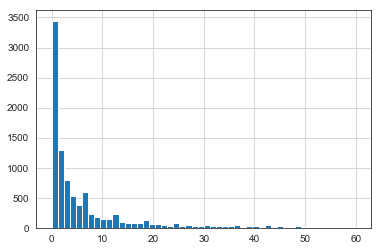

In [101]:
movies["ratingCount"].hist(bins=50, range=(0, 60)) #для большей наглядности смотрим до 60, иначе хвост будет дилнный

In [107]:
movies[movies["year"]==-1]["movieId"]

6059     40697
9031    140956
9091    143410
9138    147250
9179    149334
9259    156605
9367    162414
9448    167570
9514    171495
9515    171631
9518    171749
9525    171891
9611    176601
Name: movieId, dtype: int64